# Simple Linear Regression with Neural Net

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

In [2]:
# 일반적으로 python의 class를 이용해 모델을 구현합니다.
# 일반적으로__init__, forward, predict 등으로 이루어져 있습니다.
# class에 대한 내용은 https://wikidocs.net/28 을 참고하면 되겠습니다.

class SimpleLinearRegression(nn.Module):
    def __init__(self):
        super(SimpleLinearRegression, self).__init__()
        self.Layer = nn.Linear(1, 1) # feature가 1이고 output 역시 1개이기 때문에 (1,1)입니다.
    
    #feed forward
    def forward(self, inputs):
        x = self.Layer(inputs)
        return x
    
    def predict(self, test_input):
        x = self.Layer(test_input)
        return x


model = SimpleLinearRegression() # 객체 설정
criterion = nn.MSELoss() # regression의 loss function은 MSE입니다(mean squared error)

# gradient descent로 w,b를 찾고 optimizer는 stochastic gradient descent를 사용해보겠습니다.
# momentum은 관성을 추가하는 내용입니다. 학습 속도를 위해 추가했습니다.
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.01)

In [3]:
for i in range(1000):
    
    # y = 2x + 0.1
    # input은 일정하게 1.0, 2.0, 3.0이 들어가고 target은 2.1,4.1,6.1입니다.
    # 우리가 원하는 것은 w,b가 1000번의 학습을 통해 2와 0.1이 되는 것입니다.
    inputs = torch.Tensor([1.0, 2.0, 3.0]).unsqueeze(1)
    targets = torch.Tensor([2.1, 4.1, 6.1]).unsqueeze(1)
                          
    model.zero_grad()
    y_pred = model(inputs)
    
    loss = criterion(y_pred, targets)
    loss.backward()
    
    # 계산된 gradient를 기반으로 optimizer를 이용해 w와 b를 update 합니다.
    optimizer.step()
    
    
    if i % 200 == 0:
        print(loss)

tensor(23.0428, grad_fn=<MseLossBackward>)
tensor(9.0457e-08, grad_fn=<MseLossBackward>)
tensor(9.4739e-14, grad_fn=<MseLossBackward>)
tensor(1.8948e-14, grad_fn=<MseLossBackward>)
tensor(7.5791e-14, grad_fn=<MseLossBackward>)


In [4]:
# 1000번 학습한 결과 w는 2, b는 0.1이 되었습니다.
w = list(model.parameters())
print(w)

[Parameter containing:
tensor([[2.0000]], requires_grad=True), Parameter containing:
tensor([0.1000], requires_grad=True)]


In [5]:
model.predict(torch.Tensor([10.0]))

tensor([20.1000], grad_fn=<ThAddBackward>)

# Simple Linear Regression in Statistics

- 통계학에서 배운 OLS(ordinary least square) 방식의 simple linear regression(단순선형회귀)과 비교해보겠습니다.

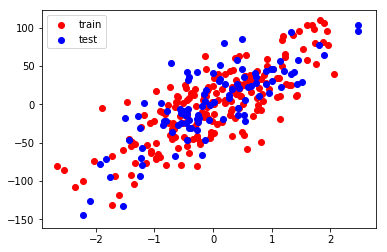

In [15]:
%matplotlib inline
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score

import numpy as np
import matplotlib.pyplot as plt
import random

seed = 777
np.random.seed(seed)

# 단순 선형 회귀를 위한 임의의 데이터셋을 생성합니다.
X, y = make_regression(n_samples=300, n_features=1, noise=30.0, random_state=seed)

X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]


# 산점도를 그려보겠습니다.

plt.scatter(X_train,y_train, c="r")
plt.scatter(X_test,y_test, c="b")
plt.legend(["train", "test"])
plt.show()

Mean Squared Error : 872.5445482700915
y = 39.1679X + -1.5085
Mean Squared Error : 820.7126317168555
R^2 : 0.6436611039385312


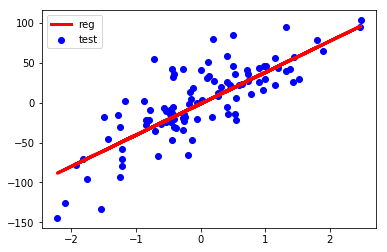

In [16]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error :",mse)
print("y = %.4fX + %.4f"%(float(model.coef_[0]),float(model.intercept_)))
# training set에 대해 mse가 최소가 되는 w와 b를 찾습니다. w = 39.1679, b = -1.5085

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)
# test set에 대해 mse와 R^2를 구한 결과 다음과 같습니다.
# mse = 820.71, R^2 = 0.64

plt.scatter(X_test, y_test, c="b")
plt.plot(X_test, y_pred, c="r", linewidth=3)
plt.legend(["reg","test"])
plt.show()

# Simple Linear Regression with Neural Net

- 이번에는 neural net으로 simple linear regression을 구현해보겠습니다.

In [17]:
# 앞으로 매우 자주 보게 될 코드 블럭입니다.
# dataset을 만들고 dataloader로 불러옵니다.

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class makeData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    # __getitem__은 index번째의 데이터를 출력합니다.
    def __getitem__(self, index):
        return (self.X_data[index], self.y_data[index])
    
    # __len_은 dataset의 길이를 출력합니다.
    def __len__(self):
        return len(self.y_data)

train_data = makeData(X_train, y_train)
test_data = makeData(X_test, y_test)

In [18]:
class SimpleLinearRegression(nn.Module):
    def __init__(self):
        super(SimpleLinearRegression, self).__init__()
        self.Layer = nn.Linear(1, 1)

    def forward(self, inputs):
        x = self.Layer(inputs)
        return x
    
    def predict(self, test_input):
        x = self.Layer(test_input)
        return x

model = SimpleLinearRegression()
criterion = nn.MSELoss()

In [19]:
# training set을 1000번 정도 학습시켜보겠습니다.

EPOCHS = 1000
BATCH_SIZE = 200

model = SimpleLinearRegression()
criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

# data loader가 train_data에서 batch_size만큼 shuffle해가며 뽑아옵니다.
# 여기서는 200개를 1000번 뽑아오겠죠?
train_batch = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    
    # X_batch와 y_batch로 train_batch의 데이터를 불러옵니다.
    # makeData에서 x_train과 y_train을 지정한 바 있습니다.
    # dataloader에 이 train_data를 넣었고 DataLoader를 통해 x_train과 y_train을 bath_size만큼 불러옵니다.
    for X_batch, y_batch in train_batch:
        
        inputs = torch.Tensor(X_batch.float())
        targets = torch.Tensor(y_batch.float()).unsqueeze(1)
        
        model.zero_grad()
        
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        loss.backward()
        optimizer.step()
    
    if epoch % 100 == 0:
        print(loss)

tensor(2321.3181, grad_fn=<MseLossBackward>)
tensor(872.5862, grad_fn=<MseLossBackward>)
tensor(872.5446, grad_fn=<MseLossBackward>)
tensor(872.5446, grad_fn=<MseLossBackward>)
tensor(872.5446, grad_fn=<MseLossBackward>)
tensor(872.5446, grad_fn=<MseLossBackward>)
tensor(872.5446, grad_fn=<MseLossBackward>)
tensor(872.5446, grad_fn=<MseLossBackward>)
tensor(872.5446, grad_fn=<MseLossBackward>)
tensor(872.5446, grad_fn=<MseLossBackward>)


In [20]:
w = list(model.parameters())
print("y = %.4fX + %.4f"%(w[0].item(), w[1].item()))

y = 39.1679X + -1.5085


In [21]:
y_pred = model.predict(torch.Tensor(X_test)).detach().numpy()
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)

print("Mean Squared Error :",mse)
print("R^2 :",r_square)

# 기존 방법(OLS)보다 더 높은 R^2를 가진 선형회귀식을 만들었습니다.

Mean Squared Error : 820.7126222618163
R^2 : 0.6436611080437418
